# RNN using PyTorch

In this part, we will code up RNN using Pytorch and use it for 

In [1]:
# Importing Dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import torchvision
import torchvision.transforms as transforms

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cpu


### Basic RNN Architecture

Just one layer of RNN is shown below, which is unrolled for a single time step

$$
s_t, h_t = \text{RNN}(x_t, s_{t-1})
$$

where $s_t$ is the hidden state at time $t$, and $x_t$ is the input at time $t$. The hidden state $h_t$ is passed to the next time step. The RNN function is:

\begin{align}
h_t &= \tanh{(W_{hh}h_{t-1} + W_{hx}x_t + b_h)} \\
s_t &= W_{sh}h_{t} + b_s
\end{align}


> Note:  In sequential data, we often use (seq, batch, feature) as the input shape. 

> Also: The last part of $s_t$ is not done by the RNN and we have to write it manually.

#### Built in Pytorch RNN cell

The nn.RNN module takes **(input_size, hidden_size, num_layers )** as the input and give **(output, hidden)** as the output. Default activation is tanh.

* The input_size is the number of features in the input $H_{in}$
* The hidden_size is the number of features in the hidden state $H_{out}$
* The number of layers is the number of stacked RNNs.

The outputs are:-
* output of the final hidden states for each input. (size : seq = L, batch = N, feature = $H_{out}$)
* hidden is of Shape (num_layers, batch = N, feature = $H_{out}$)

The figure is given in the repository as the image ![RNN_shapes.jpg](Recurrent_Networks/RNN_shapes.jpg)

In [13]:
# 10 input features size, 20 hidden vector size, 2 stacked RNN layers (one on top of another)
rnn = nn.RNN(10, 20, 2)

# input size: (seq_len = 5, batch = 3, input_feature_size = 10)
# output_size: (seq_len = 5, batch = 3, hidden_size = 20)

input = torch.randn(5, 3, 10)

# Initial Hidden State (num_layers , batch, hidden_size)
h0 = torch.randn(2, 3, 20)

# First output is all the hidden states, second output is the last hidden state
output, hn = rnn(input, h0)

print(output.shape, hn.shape)

torch.Size([5, 3, 20]) torch.Size([2, 3, 20])


We will use the nn.RNN module to build a simple RNN model.

In [35]:
class Model_RNNCell(nn.Module):
    def __init__(self, batch_size, input_feat, hidden_size):
        super(Model_RNNCell, self).__init__()

        # RNN hidden state of n_input features input size, and n_neurons hidden size, 1 RNN layer
        self.rnn = nn.RNNCell(input_feat, hidden_size)
        # initialize hidden state
        self.hx = torch.randn(batch_size, hidden_size)

    def forward(self, X):
        output = []

        # for each time step, we update the hidden state
        for i in range(len(X)):
            self.hx = self.rnn(X[i], self.hx)
            output.append(self.hx)

        return output, self.hx
    
FIXED_BATCH_SIZE = 4 # our batch size is fixed for now
Input_features_dim = 3
Hidden_dim = 5

# The first two inputs, X0 and X1
X_batch = torch.tensor([[[0,1,2], [3,4,5],
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0],
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float)

print(X_batch.shape) # (2,4,3)

model = Model_RNNCell(FIXED_BATCH_SIZE, Input_features_dim, Hidden_dim)
output_val, states_val = model(X_batch)

# Contains all output for all timesteps
print(output_val)
# Contain values for final state or final timestep, i.e., t=1
print(states_val.shape) 

torch.Size([2, 4, 3])
[tensor([[ 0.8834, -0.3579,  0.6471,  0.7943,  0.1292],
        [ 0.9963,  0.3830,  0.9305,  0.9901,  0.7968],
        [ 0.9999, -0.1817,  0.9992,  0.9996,  0.8681],
        [ 0.9997,  0.9990,  0.8043,  0.9408,  0.9949]],
       grad_fn=<TanhBackward0>), tensor([[1.0000, 0.9589, 0.9998, 1.0000, 0.8600],
        [0.5935, 0.6340, 0.3347, 0.1416, 0.1032],
        [0.9996, 0.9569, 0.9958, 0.9998, 0.6379],
        [0.9787, 0.9454, 0.8157, 0.9408, 0.4841]], grad_fn=<TanhBackward0>)]
torch.Size([4, 5])


In [28]:
# Checking the Model, but this will not work as it need the batch dim to be at first place
from torchsummary import summary
# summary(model, (2, 4, 3))

### RNN for Image Classification

![](https://docs.google.com/drawings/d/e/2PACX-1vSiMstqkE9hTYmhPD3KMeFRNNKYA2NnrCayahBOEL1TalRqaWF7rH8a7O-nP9c-mKOdZRsWtmAGZfNN/pub?w=969&h=368)

Here, we will use RNN for image classification on MNIST dataset.

We will make a simple RNN model which takes rows as sequence inputs and then use the final hidden state to classify the image.

![](https://docs.google.com/drawings/d/e/2PACX-1vQWhELhewvq_bHgqwf4vwDb5B9DN9-jAxeTF9Y73zr-OsW6OXC-ngxAfojivXyZEhjzLXceTZU2Ncz3/pub?w=550&h=600)

In [31]:
# Obtaining DATA
BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./MNIST_data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./MNIST_data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

100%|██████████| 9912422/9912422 [00:04<00:00, 2272573.84it/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1858051.90it/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3018455.55it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1100868.46it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



In [37]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, input_dim, hidden_dim, n_outputs):
        super(ImageRNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.input_dim = input_dim
        self.n_outputs = n_outputs

        self.basic_rnn = nn.RNN(self.input_dim, self.hidden_dim)
        # The Linear layer that maps from hidden state space to output space
        self.FC = nn.Linear(self.hidden_dim, self.n_outputs)

    def init_hidden(self,):
        # SIZE = (num_layers, batch_size, hidden_dim)
        return (torch.zeros(1, self.batch_size, self.hidden_dim))

    def forward(self, X):
        # Transforms X to dimensions: (n_steps , batch_size , Input_dim)
        X = X.permute(1, 0, 2)

        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()

        # lstm_out => n_steps, batch_size, hidden_dim (hidden states for each time step)
        # self.hidden => 1, batch_size, hidden_dim (final state from each lstm_out)
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)
        out = self.FC(self.hidden)

        return out.view(-1, self.n_outputs) # batch_size X n_output

In [38]:
# parameters
N_steps = 28
Input_dim = 28
Hidden_dim = 150
N_classes = 10
N_epochs = 10

# Model instance
model = ImageRNN(BATCH_SIZE, N_steps, Input_dim, Hidden_dim, N_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [39]:
# Training the Model over the Dataset
for epoch in range(N_epochs): 
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()

    # TRAINING ROUND
    for i, data in enumerate(trainloader):
        optimizer.zero_grad()
        model.hidden = model.init_hidden()
        inputs, labels = data
        # Reshaping the inputs
        inputs = inputs.view(-1, 28,28)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)

    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f'
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7580 | Train Accuracy: 75.96
Epoch:  1 | Loss: 0.3617 | Train Accuracy: 89.62
Epoch:  2 | Loss: 0.2455 | Train Accuracy: 93.22
Epoch:  3 | Loss: 0.2016 | Train Accuracy: 94.32
Epoch:  4 | Loss: 0.1741 | Train Accuracy: 95.09
Epoch:  5 | Loss: 0.1570 | Train Accuracy: 95.55
Epoch:  6 | Loss: 0.1425 | Train Accuracy: 96.00
Epoch:  7 | Loss: 0.1323 | Train Accuracy: 96.34
Epoch:  8 | Loss: 0.1234 | Train Accuracy: 96.54
Epoch:  9 | Loss: 0.1226 | Train Accuracy: 96.61


In [40]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)
    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.85


As, we can see the model does very well on the MNIST dataset.

### Using LSTM on Airline Passenger data to predict the future number of passengers

We will take the Airline passenger data and use LSTM to predict the future number of passengers, check if it expands well on the dataset, by learning its trend and seasonality.

The LSTM model is very similar to RNN, just that is also has another input being the cell state $c_t$, which we also have to take into account.

In [45]:
lstm = nn.LSTM(10, 20, 2)

input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)

output, (hn, cn) = lstm(input, (h0, c0))
print(output.shape, hn.shape, cn.shape)

torch.Size([5, 3, 20]) torch.Size([2, 3, 20]) torch.Size([2, 3, 20])


In [49]:
import requests

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
response = requests.get(url)

with open('airline-passengers.csv', 'wb') as file:
    file.write(response.content)


In [161]:
import pandas as pd

training_df = pd.read_csv('airline-passengers.csv')
training_df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


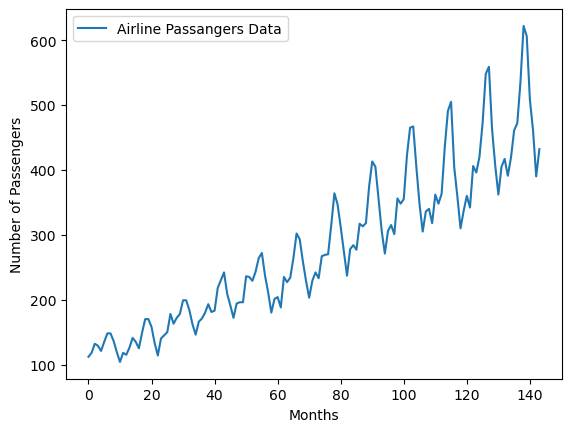

In [162]:
training_set = training_df.iloc[:,1:2].values

plt.plot(training_set, label = 'Airline Passangers Data')
plt.xlabel('Months')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

Now, we will create a dataset of sequences using sliding window, where you get 4 months of data and predict the next month.

In [169]:
from torch.autograd import Variable
# Variable is a wrapper for the Tensor, and it also holds the gradient

def sliding_windows(data, seq_length):

    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)
print(training_set[0], training_data[0])

# seq_length = 4
seq_length = 6
x, y = sliding_windows(training_data, seq_length)

# Stores the 4 previous values and the next value
print(x.shape, y.shape)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

[112] [0.01544402]
(137, 6, 1) (137, 1)


In [186]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers = 1):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        # Hense, input should be of shape (batch, seq, feature)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialise hidden and cell state with zeros
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        output, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

# We are taking all the values as the datapoints in a single batch
print(trainX.shape, trainY.shape)

torch.Size([91, 6, 1]) torch.Size([91, 1])


In [187]:
num_epochs = 4000; learning_rate = 0.01

# Input is single number, hidden_size is 2, 1 layer of LSTM
input_size = 1; hidden_size = 2; num_layers = 1
# Ouput is also single number
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [188]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs+1):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()

    optimizer.step()
    if epoch % 200 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.68938
Epoch: 200, loss: 0.01041
Epoch: 400, loss: 0.00454
Epoch: 600, loss: 0.00237
Epoch: 800, loss: 0.00219
Epoch: 1000, loss: 0.00215
Epoch: 1200, loss: 0.00211
Epoch: 1400, loss: 0.00207
Epoch: 1600, loss: 0.00203
Epoch: 1800, loss: 0.00199
Epoch: 2000, loss: 0.00196
Epoch: 2200, loss: 0.00193
Epoch: 2400, loss: 0.00189
Epoch: 2600, loss: 0.00186
Epoch: 2800, loss: 0.00184
Epoch: 3000, loss: 0.00181
Epoch: 3200, loss: 0.00178
Epoch: 3400, loss: 0.00174
Epoch: 3600, loss: 0.00171
Epoch: 3800, loss: 0.00166
Epoch: 4000, loss: 0.00163


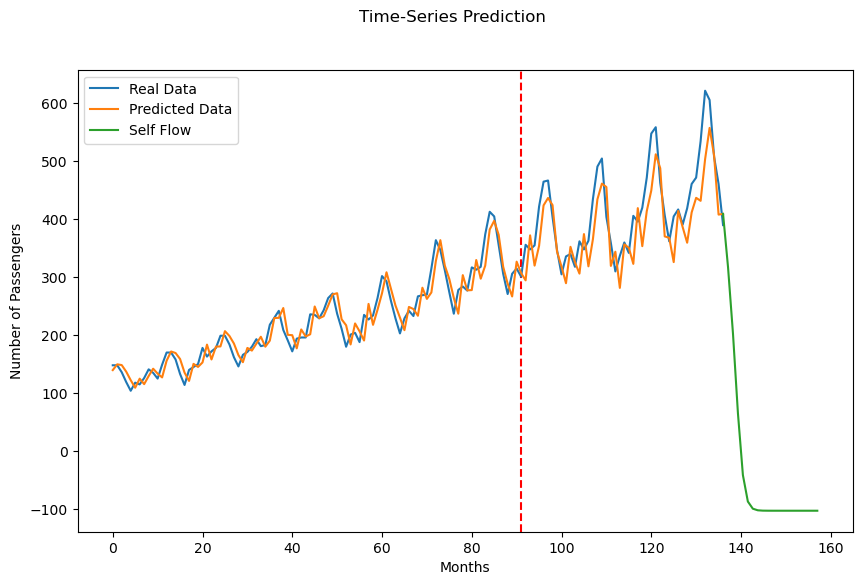

In [189]:
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

Next_Input = dataX[-1].clone()
Next_Input = Next_Input.reshape(1, seq_length, 1)

pred_len = 20
prediction = torch.zeros(pred_len)

for i in range(pred_len):
    # print(Input)
    predict = lstm(Next_Input)
    # print(predict)
    prediction[i] = predict[0, 0]

    Next_Input[0, 0:seq_length-2, 0] = Next_Input[0, 1:seq_length-1, 0].clone()
    Next_Input[0, -1, 0] = predict[0, 0]

prediction = sc.inverse_transform(prediction.reshape(-1, 1).detach().numpy())

plt.figure(figsize=(10, 6))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label = 'Real Data')
plt.plot(data_predict, label = 'Predicted Data')
plt.plot(np.linspace(len(dataY_plot)-1, len(dataY_plot)+pred_len, pred_len), prediction, label = 'Self Flow')
plt.xlabel('Months')
plt.ylabel('Number of Passengers')
plt.legend()
plt.suptitle('Time-Series Prediction')

plt.show()

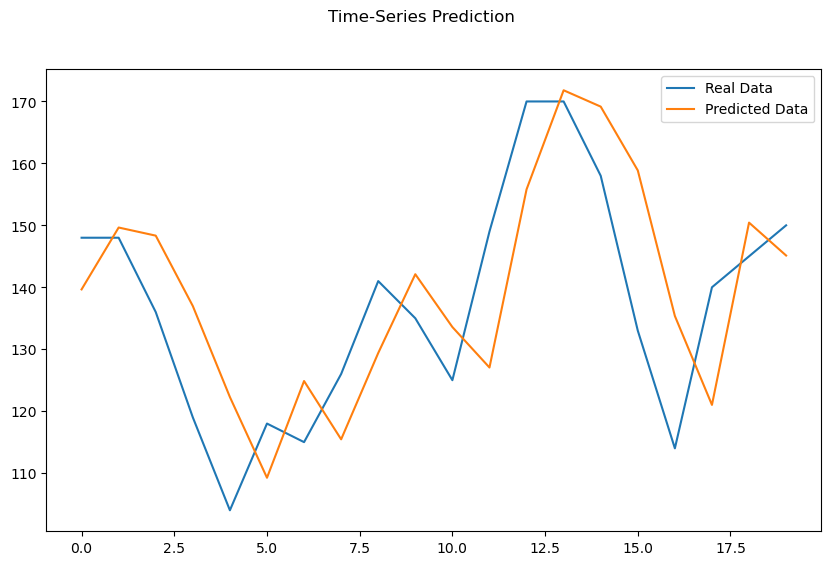

In [190]:
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(10, 6))
# plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot[0: 20], label = 'Real Data')
plt.plot(data_predict[0:20], label = 'Predicted Data')
plt.legend()
plt.suptitle('Time-Series Prediction')

plt.show()

This leads us to conclude that, the LSTM does not learn the periodic properties very well when such a small dataset is used, as it keeps going up or down depending on the trend, and unable to capture the seasonality.